Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which you'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from [the University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

* `instant` - A unique sequential ID number for each row
* `dteday` - The date of the rentals
* `season` - The season in which the rentals occurred
* `yr` - The year the rentals occurred
* `mnth` - The month the rentals occurred
* `hr` - The hour the rentals occurred
* `holiday` - Whether or not the day was a holiday
* `weekday` - The day of the week (as a number, 0 to 7)
* `workingday` - Whether or not the day was a working day
* `weathersit` - The weather (as a categorical variable)
* `temp` - The temperature, on a 0-1 scale
* `atemp` - The adjusted temperature
* `hum` - The humidity, on a 0-1 scale
* `windspeed` - The wind speed, on a 0-1 scale
* `casual` - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
* `registered` - The number of registered riders (people who had already signed up)
* `cnt` - The total number of bike rentals (casual + registered)

### Analysis Goal
I will try to predict the total number of bikes people rented in a given hour. I'll predict the `cnt` column using all of the other columns, except for `casual` and `registered`.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

bike_rentals=pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
bike_rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Sweet! Thank you Hadi Fanaee-T for providing such clean data set.

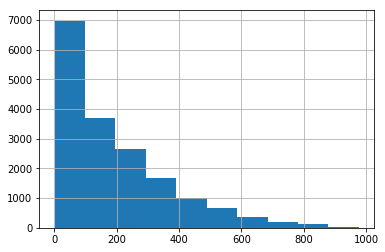

In [6]:
#histogram of target column
bike_rentals.cnt.hist()

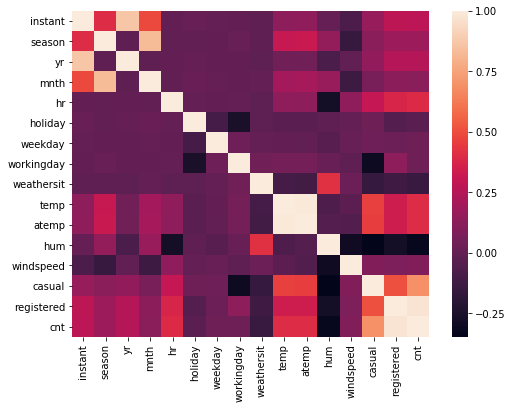

In [13]:
#looking at correlations:
corrs=bike_rentals.corr()
fig, ax=plt.subplots(figsize=(8,6))
sns.heatmap(corrs)

In [18]:
corrs['cnt'].abs().sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

registered and casual are highly correlated with cnt! at the same time, they are correlated to each other as well. So, first, considering one of them would be enough. However, if we know the number of registered bikers, we probably already know the number of total rents. Therefore, we would need to drop both columns.

Let's bundle the time! at the moment, the time is in the 1-24 period. We'd like to bundle it in morning, noon, afternoon, and evening. In this way, we can make better predictions based on time.

In [20]:
def assign_label(hr):
    if (hr >0) and (hr<=6):
        return 4
    if (hr>6) and (hr<=12):
        return 1
    if (hr>12) and (hr<=18):
        return 2
    else:
        return 3

bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)

`cnt` is a continous variable and therefore rmse would be a good measure for estimating the error of model.

In [30]:
from sklearn.metrics import mean_squared_error
train=bike_rentals.sample(frac=0.8)
test=bike_rentals.loc[~bike_rentals.index.isin(train.index)]

####  Feature selection
Registered and casual are highly correlated with cnt! at the same time, they are correlated to each other as well. So, first, considering one of them would be enough. However, if we know the number of registered bikers, we probably already know the number of total rents. Therefore, we would need to drop both columns.

Also, dtedate already exists in other forms in the data. Let's take a look at other columns.

In [32]:
bike_rentals['yr'].value_counts()

1    8734
0    8645
Name: yr, dtype: int64

Okay we'll keep the year column, just in case the prediction has anything to do with the year

In [34]:
corrs['temp'].abs().sort_values(ascending=False)

temp          1.000000
atemp         0.987672
casual        0.459616
cnt           0.404772
registered    0.335361
season        0.312025
mnth          0.201691
hr            0.137603
instant       0.136178
weathersit    0.102640
hum           0.069881
workingday    0.055390
yr            0.040913
holiday       0.027340
windspeed     0.023125
weekday       0.001795
Name: temp, dtype: float64

Obviously, temp and atemp are very correlated. I'll drop atemp.

In [39]:
from sklearn.linear_model import LinearRegression

features=['season','yr','mnth','holiday','weekday','workingday','weathersit','temp','hum','windspeed','time_label']

model=LinearRegression()
model.fit(train[features],train['cnt'])
predictions=model.predict(test[features])

rmse=(mean_squared_error(test['cnt'],predictions))**(1/2)
print('Root mean squared error is:',rmse)

Root mean squared error is: 133.306315604


The error is extremly high! let's deduct columns and test again!

In [44]:
features2=['season','holiday','weekday','workingday','weathersit','temp','hum','windspeed','time_label']
model=LinearRegression()
model.fit(train[features2],train['cnt'])
predictions=model.predict(test[features2])

rmse=(mean_squared_error(test['cnt'],predictions))**(1/2)
print('Root mean squared error is:',rmse)

Root mean squared error is: 139.560744641


Okay! error got bigger! This could be because the histogram of cnt shows small amount of high rental counts and a lot of low rental counts.

At this point, I'll switch to a different algorithm. Let's use decision trees.

In [58]:
from sklearn.tree import DecisionTreeRegressor

dt=DecisionTreeRegressor(max_depth=9)
dt.fit(train[features],train['cnt'])
predictions=dt.predict(test[features])

rmse=(mean_squared_error(test['cnt'],predictions))**(1/2)
print('Root mean squared error is:',rmse)

Root mean squared error is: 123.275045685


Okay! lower error! so let's switch to random forrest for a better precision.

In [65]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=15)
reg.fit(train[features], train["cnt"])

predictions = reg.predict(test[features])
rmse=(mean_squared_error(test['cnt'],predictions))**(1/2)
print('Root mean squared error is:',rmse)

Root mean squared error is: 117.938006513


Therefore, we decreased the error from 133 in linear regression to 117 in random forrest.